# Scenario 2: Measuring the stability of enzymes
Data provided by Amalie Vang Høst (Department of Chemical and Biochemical Engineering, Technical University of Denmark, 2800 Kgs Lyngby, Denmark)  
  
The dataset for this and all following scenarios were created by Simone Lauterbach. Usually the project partners filled out an EnzymeML spreadsheet template, which is a structured Excel file with Makros. Simone checked the spreadsheets for completeness and converted them into EnzymeML documents.  
In this scenario the time-course data from the EnzymeML document is analysed visually and initial rates are calculated. The analysis of initial rates is very common by many of our project partners and in biocatalysis in general.  
This analysis is a reproduction of the analysis done by Vang Høst in Excel, which she provided us with.

## Imports
First all necessary Python packages must be installed and imported.  
This step is the same for all scenarios and differs only in the used python packages.
If you run this notebook with Binder you don't have to install anything, Binder takes care of this.   
If you run this notebook local make sure you have all Packages installed. All needed packages with the used version can be found in the `requirements.txt`.

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pyenzyme.enzymeml.tools import EnzymeMLReader

## Reading EnzymeML with PyEnzyme software
In order to read the EnzymeML document and access its content with the PyEnzyme software the file path is defined.  
If you want to run this Jupyter Notebook locally, make sure you have the same folder structure or to change the path accordingly.  
When running the next code cell the EnzymeML document is saved in the `enzmlDoc` variable and an overview is printed below.

In [10]:
path = '../../data/Host_Measurements_orig.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLReader().readFromFile(path)
    print(enzmlDoc)
else:
    print('Incorrect file path.')

>>> Units
	ID: u0 	 Name: ml
	ID: u1 	 Name: mole / l
	ID: u2 	 Name: g / l
	ID: u3 	 Name: K
	ID: u4 	 Name: sec
>>> Reactants
	ID: s0 	 Name: Glucose
	ID: s1 	 Name: water
	ID: s2 	 Name: O2
	ID: s3 	 Name: 4-aminoantipyrine
	ID: s4 	 Name: 3,5-dichloro-2-hydroxybenzenesulfonic acid
	ID: s5 	 Name: Gluconic acid
	ID: s6 	 Name: pink product
>>> Proteins
	ID: p0 	 Name: Glucose Oxidase
>>> Reactions
	ID: r0 	 Name: Deactivation of glucose oxidase
>>> Measurements

ID    Species   Conc      Unit  
m0    p0        0.500   g / l   
m0    s0        1       mole / l
m0    s1        0       mole / l
m0    s2        0       mole / l
m0    s3        1       mole / l
m0    s4        10      mole / l
m0    s5        0       mole / l
m0    s6        0       mole / l
m1    p0        0.500   g / l   
m1    s0        1       mole / l
m1    s1        0       mole / l
m1    s2        0       mole / l
m1    s3        1       mole / l
m1    s4        10      mole / l
m1    s5        0       mole / l
m1

This experiment consists of 11 measurements and each measurement consists of 7 reactants (s0 -s6) and one protein (p0).  
For initial rate calculation only  the time-course data is needed, this is usually analysed in relation to different initial concentrations of the substrate. In this case the stability of the enzyme is of interest, therefore, all 11 measurements (m0 - m10) were carried out under identical conditions and with identical initial concentrations, but the time to add the substrate and start the reaction varied, this information was stored in the measurement names.  
Next one measurement is exemplarily examined. 

In [11]:
# Fetch the measurement
measurement0 = enzmlDoc.getMeasurement('m0')
print(measurement0.getName())
measurementDict = measurement0.getSpeciesDict()

# Access the measurement data per reactant/protein
for speciesType, speciesDict in measurementDict.items():
    # Extract all the data
    for speciesID, data in speciesDict.items():
        initConc = data.getInitConc()
        unitID = data.getUnit()
        unitString = enzmlDoc.getUnitString(unitID)
        replicates = data.getReplicates()
        print(
            f"{speciesID}: initial concentration = {initConc} {unitString} ; number of replicates = {len(replicates)}"
        )

Measurement after 0 min
p0: initial concentration = 0.5 g / l ; number of replicates = 0
s0: initial concentration = 1.0 mole / l ; number of replicates = 0
s1: initial concentration = 0.0 mole / l ; number of replicates = 0
s2: initial concentration = 0.0 mole / l ; number of replicates = 0
s3: initial concentration = 1.0 mole / l ; number of replicates = 0
s4: initial concentration = 10.0 mole / l ; number of replicates = 0
s5: initial concentration = 0.0 mole / l ; number of replicates = 3
s6: initial concentration = 0.0 mole / l ; number of replicates = 0


The overview of the initial measurement shows, that the product Gluconic acid (s5) has 3 replicates, these contain the measured time-course data.  

## Data preparation
In this experiment to analyse the stability of the enzyme only the change of the initial rates over time is of interest. Therefore only the measured time-course data and the measurement names containing the time information are stored for each measurement. In order to extract the information of the measurement time, string manipulation is used. 

In [12]:
# initialise datastructure to store experimental data
experimentalData = []

# time and substrate concentration unit
time = np.array(enzmlDoc.getMeasurement('m0').getGlobalTime(), float)
timeUnit = enzmlDoc.getUnitDict()[enzmlDoc.getMeasurement('m0').getGlobalTimeUnit()].getName()
concentrationUnit = ''

# go through all measurements:
for measurement in enzmlDoc.getMeasurementDict().values():
    name = measurement.getName()
    measurementData = {
        'name': name,
        'measuring time min': float(name.split(' ')[-2]),
        'measuring time h': float(name.split(' ')[-2])/60,
        'measured': []
    }

    # get replicates with time course data:
    reactant = measurement.getReactant('s5')
    replicates = reactant.getReplicates()
    for replicate in replicates:
        measurementData['measured'].append(replicate.getData().values.tolist())
    experimentalData.append(measurementData)

## Visualisation of time-course data
All time-course data is visualised with the Python library matplotlib. 
   
In order to save the figures as svg uncomment the `plt.savefig(...)` code lines. 

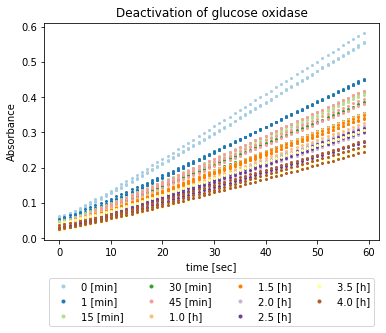

In [13]:
# define colors for time-course visualisation
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
# plot time course data with matplotlib
reaction_name = enzmlDoc.getReaction('r0').getName()
plt.figure()
ax = plt.subplot()
for i in range(len(experimentalData)):
    t = experimentalData[i]['measuring time min']
    if t < 60:
        ax.plot([], 'o', ms=3, label=str(int(t)) + ' [min]', color = colors[i])
    else:
        ax.plot([], 'o', ms=3, label=str(t/60) + ' [h]', color = colors[i])
    for measurement in experimentalData[i]['measured']:
        ax.plot(time, measurement, 'o', ms=2, color = colors[i])
plt.title(reaction_name)
ax.set_xlabel('time ['+timeUnit+']')
ax.set_ylabel('Absorbance')
plt.legend(bbox_to_anchor=(0, 0, 1, -0.15), mode="expand", ncol=4)
# save as svg
#plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

The figure shows that the curves were less steep the more time passed.

## Computation of initial rates
To calculate the initial rates the slope of the first 30 data points (0 to 29 seconds) for each replicate is calculated, to be consistent with the calculations done by Vang Høst. This is done with linear regression by the Python library SciPy.  
In order to calculate the slope of another fraction of the time-course change the `start` and `end` variable accordingly, `end` should not be greater than 59.  
Then the mean from the 3 replicates is calculated for each measurement and saved in `experimentalData`.  
With an extinction coefficient of 26 the rates are determined as follows:  
> $ rate = \frac{meanOfSlope}{26}*1000$  
>
and also stored in `experimentalData`.  
And finally the residual activity compared to the initial activity is calculated and stored as well.

In [14]:
start = 0
end = 29
for measurement in experimentalData:
    slopes = []
    for replicate in measurement['measured']:
        slope, intercept, r, p, se = stats.linregress(time[start:end], replicate[start:end])
        slopes.append(slope)
    slope = np.mean(slopes)
    measurement['slope'] = round(slope, 4)
    measurement['v0'] =  round(slope/(26)*1000, 3)
    measurement['residual activity'] = measurement['v0']/experimentalData[0]['v0']*100

## Visualisation of the rates <a class="anchor" name="RatesVisualisation"></a>
First the rates are plotted over the time.

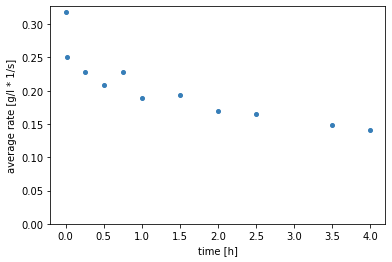

In [15]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['v0'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('average rate [g/l * 1/s]')
ax.set_ylim(ymin=0)
# save as svg
#plt.savefig('rates.svg', bbox_inches='tight')
plt.show()

Second the residual of the rates is plotted.

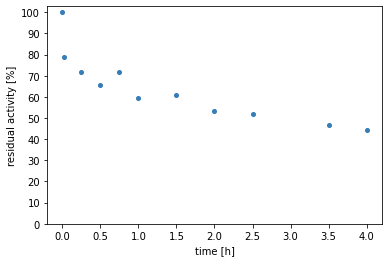

In [16]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['residual activity'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('residual activity [%]')
ax.set_yticks(np.arange(0, 105, 10))
# save as svg
#plt.savefig('residual-activity.svg', bbox_inches='tight')
plt.show()

The figures show a decrease of the initial rates over time, which corresponds to the activity of the enzyme. This suggests instability of the enzyme in the given conditions. The greatest loss of activity seems to happen very fast in the first minute.

## Upload to DaRUS 
Since this scenario is part of a paper, that is momentarily written. It was uploaded to a DataVerse for this paper on __DaRUS__ the data repository of the University of Stuttgart.  
There it got the DOI: 